In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError

### Data preparation

In [212]:
dataset, dataset_info = tfds.load('smallnorb', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])

In [213]:
training_dict = {"Image": [], "Res": []}
for item in dataset[0]:
    training_dict["Image"].append(list(item[0].numpy()))
    training_dict["Res"].append(item[1].numpy())

len(training_dict["Res"])

24300

In [214]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [215]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
list(train_dataset.take(1).as_numpy_iterator())

[(array([[[132],
          [132],
          [132],
          ...,
          [130],
          [131],
          [131]],
  
         [[131],
          [131],
          [131],
          ...,
          [130],
          [130],
          [130]],
  
         [[131],
          [131],
          [131],
          ...,
          [130],
          [130],
          [130]],
  
         ...,
  
         [[132],
          [132],
          [132],
          ...,
          [130],
          [130],
          [130]],
  
         [[132],
          [132],
          [132],
          ...,
          [131],
          [130],
          [130]],
  
         [[132],
          [132],
          [132],
          ...,
          [131],
          [131],
          [131]]], dtype=uint8),
  4)]

In [216]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(96, 96, 1), dtype=uint8, numpy=
array([[[132],
        [132],
        [132],
        ...,
        [130],
        [131],
        [131]],

       [[131],
        [131],
        [131],
        ...,
        [130],
        [130],
        [130]],

       [[131],
        [131],
        [131],
        ...,
        [130],
        [130],
        [130]],

       ...,

       [[132],
        [132],
        [132],
        ...,
        [130],
        [130],
        [130]],

       [[132],
        [132],
        [132],
        ...,
        [131],
        [130],
        [130]],

       [[132],
        [132],
        [132],
        ...,
        [131],
        [131],
        [131]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(96, 96, 1), dtype=uint8, numpy=
array([[[223],
        [223],
        [223],
        ...,
        [223],
        [223],
        [223]],

       [[223],
        [223],
        [223],
        ...,
        [223],
        [223],


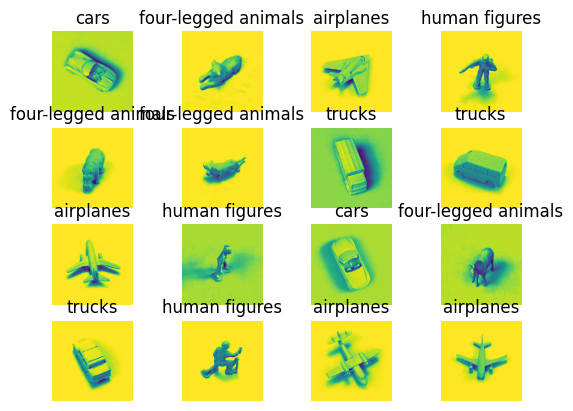

In [217]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label_category'].int2str(label))
    plt.axis('off')

In [218]:
IM_SIZE = 96
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [219]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [220]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.50980395]
  [0.5137255 ]
  [0.5137255 ]]

 [[0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 [[0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 ...

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.50980395]
  [0.50980395]
  [0.50980395]]

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.5137255 ]
  [0.50980395]
  [0.50980395]]

 [[0.5176471 ]
  [0.5176471 ]
  [0.5176471 ]
  ...
  [0.5137255 ]
  [0.5137255 ]
  [0.5137255 ]]], shape=(96, 96, 1), dtype=float32)


In [221]:
BATCH_SIZE = 4
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [186]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Flatten(),
                             Dense(100, activation='relu'),
                             BatchNormalization(),
                             Dense(10, activation='relu'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid'),
])
lenet_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 96, 96, 3)         30        
                                                                 
 batch_normalization_43 (Ba  (None, 96, 96, 3)         12        
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 48, 48, 3)         0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 48, 48, 9)         252       
                                                                 
 batch_normalization_44 (Ba  (None, 48, 48, 9)         36        
 tchNormalization)                                               
                                                     

In [222]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 1)),
                            Conv2D(16, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Conv2D(32, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Conv2D(64, 3, padding='same', activation='relu'), 
                            BatchNormalization(),
                            MaxPooling2D(), 
                            Flatten(), 
                            Dense(128, activation='relu'), 
                            BatchNormalization(),
                            Dense(30, activation='relu'),
                            BatchNormalization(),
                            Dense(5, activation='sigmoid'),
])
lenet_model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 batch_normalization_53 (Ba  (None, 96, 96, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_54 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                     

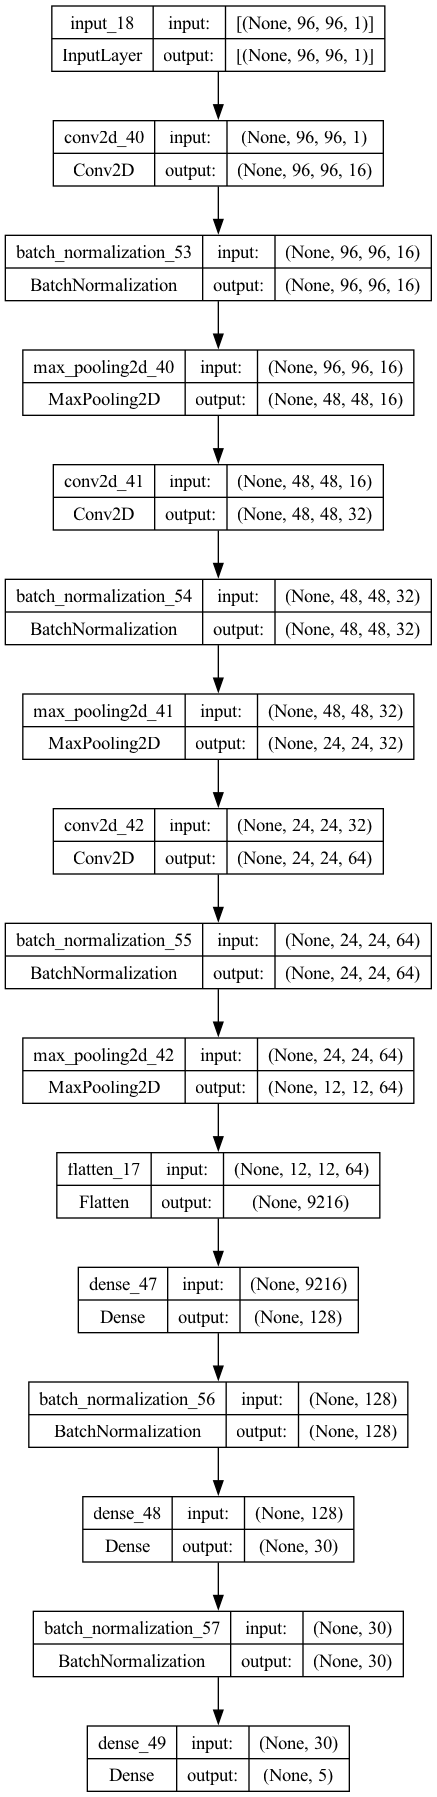

In [223]:
tf.keras.utils.plot_model(model=lenet_model, to_file="model.png", show_shapes=True)

In [242]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy( 
                  from_logits=True),
              metrics='accuracy')

In [268]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=15, verbose=1)

Epoch 1/15
4860/4860 [==============================] - 57s 12ms/step - loss: 0.2190 - accuracy: 0.9313 - val_loss: 125.2057 - val_accuracy: 0.9840
Epoch 2/15
4860/4860 [==============================] - 56s 12ms/step - loss: 0.1628 - accuracy: 0.9496 - val_loss: 0.7557 - val_accuracy: 0.9922
Epoch 3/15
4860/4860 [==============================] - 59s 12ms/step - loss: 0.1558 - accuracy: 0.9525 - val_loss: 0.0328 - val_accuracy: 0.9914
Epoch 4/15
4860/4860 [==============================] - 59s 12ms/step - loss: 0.1503 - accuracy: 0.9553 - val_loss: 8104.1055 - val_accuracy: 0.9909
Epoch 5/15
4860/4860 [==============================] - 59s 12ms/step - loss: 0.1426 - accuracy: 0.9565 - val_loss: 55.4334 - val_accuracy: 0.9621
Epoch 6/15
4860/4860 [==============================] - 60s 12ms/step - loss: 0.1380 - accuracy: 0.9576 - val_loss: 135.4271 - val_accuracy: 0.9872
Epoch 7/15
4860/4860 [==============================] - 58s 12ms/step - loss: 0.1298 - accuracy: 0.9619 - val_loss: 

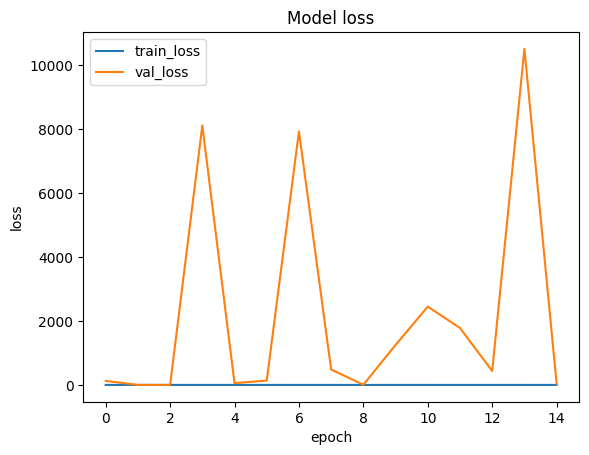

In [269]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [270]:
lenet_model.evaluate(test_dataset)

608/608 [==============================] - 3s 4ms/step - loss: 53.7960 - accuracy: 0.9901


[53.79604721069336, 0.990123450756073]

In [271]:
test_dataset = test_dataset.shuffle(buffer_size=8)

In [272]:
def decide_type(l: list):
    if (l[0] == l[1] or l[0] == l[2] or l[0] == l[3] or l[0] == l[4]
        or l[1] == l[2] or l[1] == l[3] or l[1] == l[4] or l[2] == l[3]
        or l[2] == l[4] or l[3] == l[4]):
        return "underfined"
    if np.argmax(l) == 0:
        return "animal"
    if np.argmax(l) == 1:
        return "human"
    if np.argmax(l) == 2:
        return "plane"
    if np.argmax(l) == 3:
        return "truck"
    if np.argmax(l) == 4:
        return "car"

1/1 [==============================] - 0s 15ms/step
[6.9364961e-03 9.4931275e-01 1.6422028e-06 7.6370998e-06 1.1980727e-06]
1/1 [==============================] - 0s 16ms/step
[0.96721125 0.83557785 1.         0.96627766 0.99893624]
1/1 [==============================] - 0s 16ms/step
[0.9914809  0.9999994  0.98541975 0.97033834 0.9297549 ]
1/1 [==============================] - 0s 16ms/step
[5.2474816e-03 1.4956864e-06 2.1007765e-05 1.2121947e-07 2.4825606e-06]
1/1 [==============================] - 0s 17ms/step
[0.99999696 1.         0.9999978  0.9999991  0.99989945]
1/1 [==============================] - 0s 17ms/step
[5.2933991e-03 8.5428886e-12 7.0366622e-11 1.2302276e-11 1.9573275e-10]
1/1 [==============================] - 0s 16ms/step
[6.8385345e-01 9.9997395e-01 2.1694627e-02 2.1188959e-02 5.3811027e-04]
1/1 [==============================] - 0s 16ms/step
[3.6197002e-03 3.7305519e-05 1.9363860e-03 9.9985665e-01 3.9495463e-03]
1/1 [==============================] - 0s 15ms/step
[

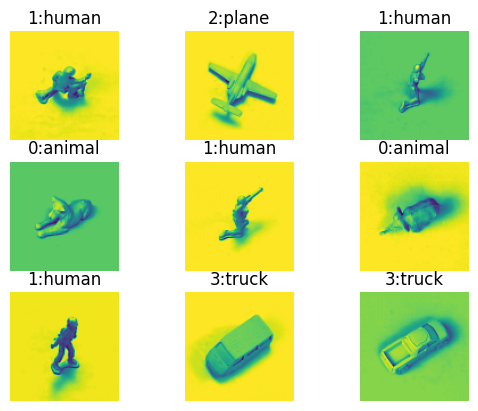

In [273]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(str((label.numpy()[0])) + ":" + str(decide_type(lenet_model.predict(image)[0])))
    print(lenet_model.predict(image)[0])
    plt.axis('off')